## Ceph Telemetry Data EDA

The Ceph team recently started collecting disk data provided by their users. This notebook shows how to access that data, and explores the content of the dataset on a high level. This notebook also looks to contrast this **Telemetry** dataset to the previously explored **BackBlaze** data. The data is available [here](https://kzn-swift.massopen.cloud/swift/v1/devicehealth/).

In [1]:
import wget
import requests
import json
from tqdm import tqdm
import zipfile
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

sns.set(rc={"figure.figsize": (11.7, 8.27)})

## Loading the data

First, we'll look at the different data sets we are able to download.

In [2]:
url = "https://kzn-swift.massopen.cloud/swift/v1/devicehealth/"

In [3]:
r = requests.get(url, allow_redirects=True)
files = r.text.split(sep="\n")
files

['device_health_metrics_2020-01.zip',
 'device_health_metrics_2020-02.zip',
 'device_health_metrics_2020-03.zip',
 'device_health_metrics_2020-04.zip',
 'device_health_metrics_2020-05.zip',
 'device_health_metrics_2020-06.zip',
 'device_health_metrics_2020-07.zip',
 'device_health_metrics_2020-08.zip',
 'device_health_metrics_2020-09.zip',
 'device_health_metrics_2020-10.zip',
 'device_health_metrics_2020-11.zip',
 'device_health_metrics_2020-12.zip',
 'device_health_metrics_2021-01.zip',
 'device_health_metrics_2021-02.zip',
 'device_health_metrics_2021-03.zip',
 'device_health_metrics_2021-04.zip',
 'device_health_metrics_2021-05.zip',
 'device_health_metrics_2021-06.zip']

In [4]:
file_name = "device_health_metrics_2020-01"

In [5]:
url = url + f"{file_name}.zip"

In [6]:
zipped_data = wget.download(url)

In [7]:
with zipfile.ZipFile(f"{file_name}.zip", "r") as zip_ref:
    zip_ref.extractall("../../../data/telemetry")

In [8]:
health_data = pd.read_csv(f"../../../data/telemetry/{file_name}.csv")
health_data.head()

,ts,device_uuid,invalid,report
0,2020-01-20 15:01:17,30c613da-3ee6-11ea-afb2-0025900057ea,t,"{""dev"": ""/dev/sdb"", ""error"": ""smartctl failed""..."
1,2020-01-20 15:01:18,30b5dc0e-3ee6-11ea-afb2-0025900057ea,t,"{""dev"": ""/dev/sdc"", ""error"": ""smartctl failed""..."
2,2020-01-20 15:01:19,30a59e48-3ee6-11ea-afb2-0025900057ea,t,"{""dev"": ""/dev/sdd"", ""error"": ""smartctl failed""..."
3,2020-01-20 15:01:20,30b34b24-3ee6-11ea-afb2-0025900057ea,t,"{""dev"": ""/dev/sde"", ""error"": ""smartctl failed""..."
4,2020-01-20 15:01:20,30bcc5c8-3ee6-11ea-afb2-0025900057ea,t,"{""dev"": ""/dev/sdf"", ""error"": ""smartctl failed""..."


## Exploring dataset contents

We first are interested in understanding how many devices we are looking at, and how many data points are associated with each device.

In [9]:
# how many devices do we have data from?
health_data["device_uuid"].nunique()

89

In [10]:
# how many data points do we have from device?
health_data["device_uuid"].value_counts()

30a81844-3ee6-11ea-afb2-0025900057ea    17
30c613da-3ee6-11ea-afb2-0025900057ea    17
30aef7c2-3ee6-11ea-afb2-0025900057ea    16
30c88304-3ee6-11ea-afb2-0025900057ea    16
30b5dc0e-3ee6-11ea-afb2-0025900057ea    16
                                        ..
0e8d2da2-4390-11ea-8497-0cc47a635394     4
5c058d0a-4459-11ea-a135-0cc47ad2c770     4
5c0dbfb6-4459-11ea-a135-0cc47ad2c770     4
5bfae076-4459-11ea-a135-0cc47ad2c770     4
a26045dd-40a4-11ea-aeb4-002590005994     1
Name: device_uuid, Length: 89, dtype: int64

In [11]:
# how many of these data points had valid data?
health_data.invalid.value_counts()

f    792
t    310
Name: invalid, dtype: int64

**RESULT** Based on the above outputs, it looks like we have data from 89 unique devices. The number of data points from each device ranges from 1 to 17. Furthermore, roughly 72% of these data points have valid data.

In [12]:
# drop invalid data
health_data = health_data[health_data["invalid"] == "f"]
health_data.shape

(792, 4)

In [13]:
# convert json strings to python dicts
health_data["report"] = health_data["report"].apply(lambda x: json.loads(x))

In [14]:
# unroll device data column to get a flat df of features
unrolled_health_data = pd.json_normalize(health_data["report"])
unrolled_health_data.head()

,vendor,host_id,product,revision,model_name,nvme_vendor,scsi_version,rotation_rate,logical_block_size,json_format_version,...,nvme_smart_health_information_log.media_errors,nvme_smart_health_information_log.power_cycles,nvme_smart_health_information_log.power_on_hours,nvme_smart_health_information_log.data_units_read,nvme_smart_health_information_log.unsafe_shutdowns,nvme_smart_health_information_log.data_units_written,nvme_smart_health_information_log.num_err_log_entries,nvme_smart_health_information_log.controller_busy_time,nvme_total_capacity,nvme_unallocated_capacity
0,Hitachi,6942c3b2-3c97-11ea-aeb4-002590005994,HUA722010CLA330,R001,Hitachi HUA722010CLA330,hitachi,SPC-3,10000.0,512,"[1, 0]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Seagate,30930e18-3ee6-11ea-afb2-0025900057ea,ST31000528AS,R001,Seagate ST31000528AS,seagate,SPC-3,10000.0,512,"[1, 0]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Hitachi,30957ee6-3ee6-11ea-afb2-0025900057ea,HUA722010CLA330,R001,Hitachi HUA722010CLA330,hitachi,SPC-3,10000.0,512,"[1, 0]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Hitachi,3099dcb6-3ee6-11ea-afb2-0025900057ea,HUA722010CLA330,R001,Hitachi HUA722010CLA330,hitachi,SPC-3,10000.0,512,"[1, 0]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Hitachi,30957ee6-3ee6-11ea-afb2-0025900057ea,HUA722010CLA330,R001,Hitachi HUA722010CLA330,hitachi,SPC-3,10000.0,512,"[1, 0]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# how many disks had smartctl run successfully
unrolled_health_data["smartctl.exit_status"].value_counts()

0    493
4    299
Name: smartctl.exit_status, dtype: int64

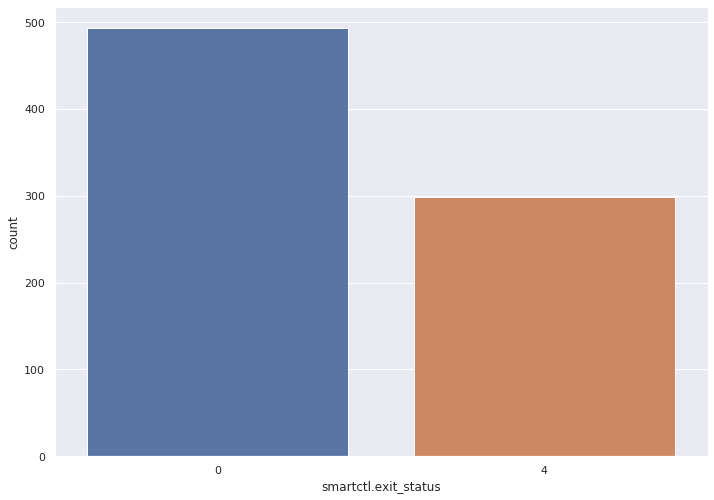

In [16]:
sns.countplot(
    x="smartctl.exit_status",
    data=unrolled_health_data,
    order=unrolled_health_data["smartctl.exit_status"].value_counts().index,
)
plt.show()

**RESULT** From the above cell, it looks like for most of the data points, smartctl ran successfully with exit code 0 (no errors at all). For some, we had smartctl exit code 4 (i.e. bit 2 was raised), which means some smartctl attributes could not be fetched (as per docs here - https://linux.die.net/man/8/smartctl). In all cases, we have at least some valid smart attributes from each device.

In [17]:
# extract smart metrics
smart_metrics_df = unrolled_health_data["ata_smart_attributes.table"].to_frame()

# numerical index of column ata_smart_attributes
for row_idx in tqdm(range(len(smart_metrics_df))):
    # get the smart stats for current drive
    stats = smart_metrics_df.iloc[row_idx]["ata_smart_attributes.table"]

    if isinstance(stats, list):
        for stat in stats:
            # extract normalized value, and int form of raw value
            smart_metrics_df.at[
                row_idx, "smart_" + str(stat["id"]) + "_normalized"
            ] = stat["value"]
            smart_metrics_df.at[row_idx, "smart_" + str(stat["id"]) + "_raw"] = stat[
                "raw"
            ]["value"]

smart_metrics_df.drop(columns=["ata_smart_attributes.table"], inplace=True)
smart_metrics_df.dropna(how="all").head()

100%|██████████| 792/792 [00:01<00:00, 534.69it/s] 


,smart_5_normalized,smart_5_raw,smart_9_normalized,smart_9_raw,smart_12_normalized,smart_12_raw,smart_177_normalized,smart_177_raw,smart_179_normalized,smart_179_raw,...,smart_206_normalized,smart_206_raw,smart_210_normalized,smart_210_raw,smart_246_normalized,smart_246_raw,smart_247_normalized,smart_247_raw,smart_248_normalized,smart_248_raw
223,100.0,0.0,99.0,1136.0,99.0,2.0,99.0,1.0,100.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
226,100.0,0.0,99.0,1148.0,99.0,2.0,100.0,0.0,100.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
227,100.0,0.0,62.0,33997.0,100.0,50.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
228,100.0,0.0,100.0,2070.0,100.0,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
229,100.0,0.0,62.0,33997.0,100.0,51.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The `telemetry` dataset differs from `backblaze` since it includes different vendors, so we want to have an overview of the different vendors that exist in this dataset. Having a list of vendors can be useful for deeper exploration, and knowing how often each vendor is used can help us control for the popularity of each vendor when looking at failure counts.

In [18]:
unrolled_health_data["nvme_vendor"].value_counts()

hitachi                    209
lvm                        177
crucial_ct1024m550ssd1     138
st2000nx0253                50
na                          49
seagate                     37
wdc_wds200t2b0a-00sm50      35
samsung_ssd_860_qvo_4tb     27
wdc_wds400t2b0a-00sm50      25
samsung_ssd_850_evo_1tb     17
intel                       16
samsung_ssd_860_evo_4tb      8
centos-0_ssd                 4
Name: nvme_vendor, dtype: int64

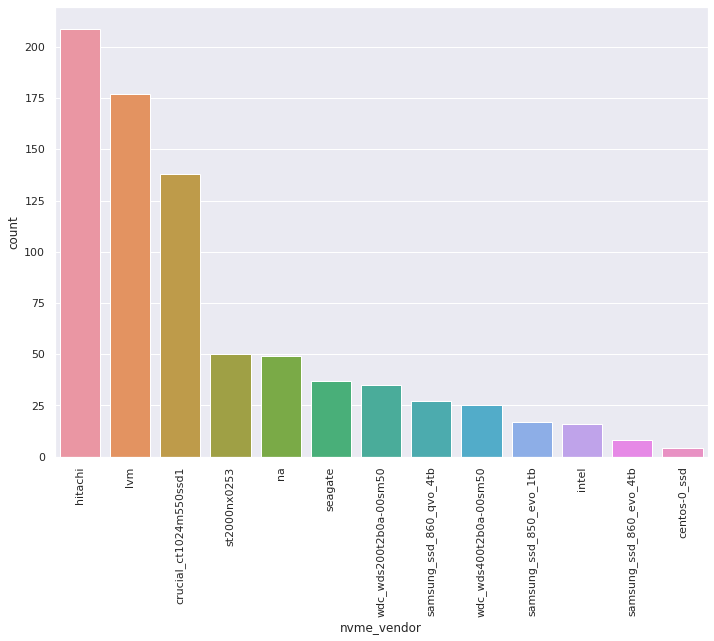

In [19]:
sns.countplot(
    x="nvme_vendor",
    data=unrolled_health_data,
    order=unrolled_health_data["nvme_vendor"].value_counts().index,
)
plt.xticks(rotation=90)
plt.show()

Our initial overview of the different vendors gives us a few different insights. One, it becomes apparent that there is still more data cleaning to be done as some vendor names are a mix of vendor name and disk model name. Secondk we see that "NA" is one of our most used vendors. It may be necessary to look into other columns for clues on the vendor, or find a different way to elegantly deal with NA values without reducing the integrity of our data.

We also want to are interested to see how often each disk model is used.

In [20]:
unrolled_health_data["model_name"].value_counts()

Hitachi HUA722010CLA330    185
WDC WDS200T2B0A-00SM50     155
Crucial_CT1024M550SSD1     138
ST2000NX0253                50
NA HUA721010KLA330          49
Samsung SSD 860 QVO 4TB     43
Seagate ST31000528AS        37
WDC  WDS400T2B0A-00SM50     33
Samsung SSD 860 EVO 4TB     24
Samsung SSD 850 EVO 1TB     17
INTEL SSDPE2MX012T4         16
Hitachi HDS721010CLA330     12
Hitachi HUA721010KLA330     12
INTEL SSDPE2ME400G4          9
INTEL SSDPE2KX040T7          8
CentOS-0 SSD                 4
Name: model_name, dtype: int64

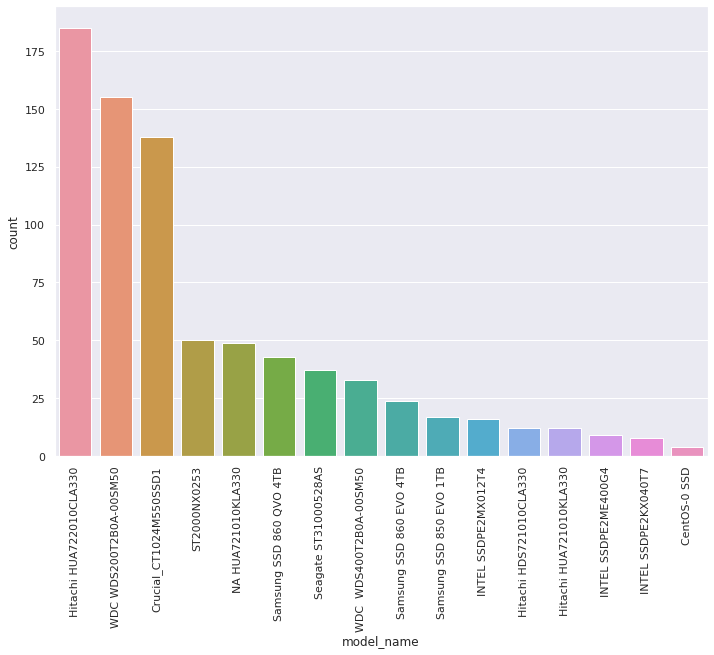

In [21]:
sns.countplot(
    x="model_name",
    data=unrolled_health_data,
    order=unrolled_health_data["model_name"].value_counts().index,
)
plt.xticks(rotation=90)
plt.show()

This can help us understand the overall distribution of different disks used, which look to be primarily _Hitachi HUA722010CLA330_, _WDC WDS200T2B0A-00SM50_, and _Crucial_CT1024M550SSD1_. 

## Conclusion

This dataset differs from `backblaze` as we are no longer just limited to one data center. With a variety of users and their differentiated use cases, we are able to have a more diverse dataset. Along with an increase in diversity of vendors, we also have many 16 different disk models to analyze how they perform. Finally, this dataset has many more variables for smartcl, allowing us to better understand the hard disk information that smartctl provides.
